# Machine Learning in Python - Project 2

Due Friday, Apr 11th by 4 pm.

*Include contributors names in notebook metadata or here*

## Setup

*Install any packages here, define any functions if neeed, and load data*

In [1]:
# Add any additional libraries or submodules below
import missingno as msno
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from imblearn.over_sampling import SMOTE
# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel

In [2]:
# Load data in easyshare.csv
d = pd.read_csv("freddiemac.csv")
d.head()

C:\Users\s2627001.ED.001\AppData\Local\Temp\ipykernel_4056\2212289888.py:2: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv("freddiemac.csv")


,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,seller_name,servicer_name,flag_sc,id_loan_rr,program_ind,rr_ind,property_val,io_ind,mi_cancel_ind,loan_status
0,809,201705,N,204704,NaN,0,1,P,75,38,...,Other sellers,SPECIALIZED LOAN SERVICING LLC,NaN,NaN,9,NaN,2,N,7,prepaid
1,702,201703,N,203202,NaN,0,1,P,80,36,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,active
2,792,201703,N,204702,NaN,0,1,S,60,36,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,prepaid
3,776,201703,N,204702,NaN,0,1,S,80,18,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,prepaid
4,790,201703,N,204702,41620.0,0,1,I,75,42,...,Other sellers,"PNC BANK, NA",NaN,NaN,9,NaN,2,N,7,active


# Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a professional body (e.g. Freddie Mac).*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

# Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft and the appropriate type of plot and summary for each variable type - your report should include figures but they should be as focused and impactful as possible.*

*You should also split your data into training and testing sets, ideally before you look to much into the features and relationships with the target*

*Additionally, this section should also motivate and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. Pipelines should be used and feature engineering steps that are be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

**3.1 Data Preparation**

In [3]:
# Proportion view of loan_status
d["loan_status"].value_counts(normalize=True) * 100

loan_status
prepaid    62.9795
active     36.6475
default     0.3730
Name: proportion, dtype: float64

统计结果显示绝大部分贷款已提前还清或仍在正常偿还，违约样本极少。数据显示，在20万笔贷款中，违约约仅占0.37%，呈现出高度不平衡的类别分布。由于“active”贷款尚未有最终结果，根据业务指示，我们只关注区分提前还清和违约两类。因此，在后续建模中，我们将过滤掉loan_status为“active”的贷款，仅使用“prepaid”和“default”两类来训练模型，并将“default”视作正类。
Statistical results show that the vast majority of loans have either been prepaid or are still in normal repayment, with default cases being relatively rare. The data indicates that among 200000 loans, defaults account for only about 0.37%, reflecting a highly imbalanced class distribution. Since “active” loans do not yet have a final outcome, and based on business guidance, we focus only on distinguishing between prepaid and defaulted loans. Therefore, in the subsequent modeling process, we will filter out loans with a `loan_status` of “active” and use only “prepaid” and “default” loans for training, treating “default” as the positive class. This approach avoids labeling unresolved loans as negative samples, thereby enhancing the model's accuracy in predicting future defaults.

In [4]:
# Filter out loans that are still being repaid, keeping only prepaid and defaulted samples
d = d[d['loan_status'] != 'active'].copy()

# Add a new label column: default = 1, prepaid = 0
d['default_flag'] = (d['loan_status'] == 'default').astype(int)

**Add new feature**

In [5]:
# Add a new feature 'is_harp_loan' to indicate if a loan is a HARP l
d['is_harp_loan'] = ((d['rr_ind'] == 'Y') & (d['ltv'] > 80)).astype('object')

# Add a new feature 'msa' to indicate if loan is in MSA or MD
d['msa'] = d['cd_msa'].notnull().astype('object')

# Add a new feature 'Nat_A' to indicate where the loan belong
d['zipcode'] = d['zipcode'].astype(str)

# Add a new feature for the national area code
d['Nat_A'] = d['zipcode'].apply(lambda x: '0' if len(x) < 5 else x[0]).astype('object')

**Remove irrelevant features**:

`id_loan`: change to index

`prod_type`: constantly "FRM" throughout the dataset and shows no variation, drop

`ppmt_pnlty`: consistently "N", no information gain, drop

`io_ind`: consistently "N", no information gain, drop

`dt_matr`: can be derived from the `dt_first_pi` and `orig_loan_term` and are of limited predictive value, drop (explain why keep `dt_first_pi`)

`id_loan_rr`and `rr_ind`: relate to loan refinancing/ have multicollinearity, drop

`servicer_name` and `seller_name`: drop, (by references)

`cd_msa` and `zipcode`: creat the new features which summary these features (by references)

In [6]:
# Replace Index with id_loan
d = d.set_index('id_loan')

# Remove irrelevant features
drop_cols = ['loan_status','prod_type', 'ppmt_pnlty', 'io_ind', 'id_loan_rr','rr_ind','dt_matr','cd_msa','zipcode', 'seller_name','servicer_name']
d.drop(columns=[c for c in drop_cols if c in d.columns], inplace=True)

d.head()

,fico,dt_first_pi,flag_fthb,mi_pct,cnt_units,occpy_sts,cltv,dti,orig_upb,ltv,...,orig_loan_term,cnt_borr,flag_sc,program_ind,property_val,mi_cancel_ind,default_flag,is_harp_loan,msa,Nat_A
id_loan,,,,,,,,,,,,,,,,,,,,,
F17Q10000002,809,201705,N,0,1,P,75,38,195000,75,...,360,1,NaN,9,2,7,0,False,False,1
F17Q10000064,792,201703,N,0,1,S,60,36,87000,60,...,360,2,NaN,9,2,7,0,False,False,4
F17Q10000065,776,201703,N,0,1,S,80,18,106000,80,...,360,2,NaN,9,2,7,0,False,False,1
F17Q10000176,687,201703,N,0,1,P,80,45,619000,75,...,360,2,NaN,9,2,7,0,False,True,9
F17Q10000301,758,201703,N,0,1,P,53,999,64000,53,...,180,1,NaN,9,3,7,0,False,False,9


**Handling NaN Values and Pseudo-NaN Values**:

numerical:

`fico`: typically ranges from 300 to 850, but a value of 9999 indicates not available

`mi_pct`, `cltv`, `dti` and `ltv`: a value of 999 indicates not available

`property_val`: a value of 9 indicates not available

categorical:

`flag_sc`: 'NaN' indicates NaN

`program_ind`: '9' indicates NaN

`mi_cancel_ind`:  '7' and '9' indicate NaN

In [7]:
# Replace pseudo-missing numeric codes with NaN
d.replace({'fico': {9999: np.nan}, 'mi_pct': {999: np.nan}, 'cltv': {999: np.nan}, 'dti': {999: np.nan},
           'ltv': {999: np.nan}, 'property_val': {9: np.nan}}, inplace=True)

# Replace categorical pseudo-missing codes with consistent label
#d['flag_sc'] = d['flag_sc'].fillna('N')
d['program_ind'] = d['program_ind'].replace('9', np.nan)
d['mi_cancel_ind'] = d['mi_cancel_ind'].replace({'7': np.nan, '9': np.nan})

d.head()

,fico,dt_first_pi,flag_fthb,mi_pct,cnt_units,occpy_sts,cltv,dti,orig_upb,ltv,...,orig_loan_term,cnt_borr,flag_sc,program_ind,property_val,mi_cancel_ind,default_flag,is_harp_loan,msa,Nat_A
id_loan,,,,,,,,,,,,,,,,,,,,,
F17Q10000002,809.0,201705,N,0.0,1,P,75.0,38.0,195000,75.0,...,360,1,NaN,NaN,2.0,NaN,0,False,False,1
F17Q10000064,792.0,201703,N,0.0,1,S,60.0,36.0,87000,60.0,...,360,2,NaN,NaN,2.0,NaN,0,False,False,4
F17Q10000065,776.0,201703,N,0.0,1,S,80.0,18.0,106000,80.0,...,360,2,NaN,NaN,2.0,NaN,0,False,False,1
F17Q10000176,687.0,201703,N,0.0,1,P,80.0,45.0,619000,75.0,...,360,2,NaN,NaN,2.0,NaN,0,False,True,9
F17Q10000301,758.0,201703,N,0.0,1,P,53.0,NaN,64000,53.0,...,180,1,NaN,NaN,3.0,NaN,0,False,False,9


To handle pseudo-NaN values, we apply different strategies based on variable type. For numerical features, special codes such as 999 or 9999 are replaced with NaN, since these values do not carry valid quantitative meaning and should be treated as true missing data. This allows for appropriate downstream handling, such as imputation or row exclusion, and prevents misleading the model with extreme or invalid values.

In contrast, for categorical features, pseudo-NaN codes like '9' or '7' are replaced with a consistent label 'N', representing “Not Available.” This preserves the categorical structure of the data while allowing the model to treat missingness as a distinct, learnable category.

In [8]:
# Convert dt_first_pi, cnt_units, cnt_borr, property_val column to object class since it is categorical
d['dt_first_pi'] = d['dt_first_pi'].rank(method='dense').astype('object')
d['cnt_units'] = d['cnt_units'].astype('object')
d['cnt_borr'] = d['cnt_borr'].astype('object')
d['property_val'] = d['property_val'].astype('object')

# Create a list of categorical columns
categorical_features = d.select_dtypes(include=['object']).columns.tolist()
print(categorical_features)

# Create a list of numerical columns
numerical_features = d.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(numerical_features)

['dt_first_pi', 'flag_fthb', 'cnt_units', 'occpy_sts', 'channel', 'st', 'prop_type', 'loan_purpose', 'cnt_borr', 'flag_sc', 'program_ind', 'property_val', 'mi_cancel_ind', 'is_harp_loan', 'msa', 'Nat_A']
['fico', 'mi_pct', 'cltv', 'dti', 'orig_upb', 'ltv', 'int_rt', 'orig_loan_term']


**3.2 Test-Training Split**

In [9]:
# Split the data into training and testing sets (stratified by default label)
X = d.drop(columns=['default_flag'])
y = d['default_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

print("Training set size:", X_train.shape, "Default rate:", y_train.mean())
print("Test set size:", X_test.shape, "Default rate:", y_test.mean())

Training set size: (101364, 24) Default rate: 0.0058896649698117675
Test set size: (25341, 24) Default rate: 0.0058797995343514466


**3.3 Missing data check**

In [10]:
missing_counts = X_train[numerical_features].isnull().sum()
missing_percent = (missing_counts / len(X_train)) * 100
# Get the maximum missing percentage
# max_missing = missing_percent.max()
# Visualize missingness
# msno.matrix(X_train, figsize=(9, 2), fontsize=10, sparkline=False)
# plt.title("Missing Values Matrix")
# plt.show()
# print(f"Maximum missing percentage for a variable: {max_missing:.2f}%")
print(missing_percent[missing_percent > 0])

fico    0.019731
cltv    0.000987
dti     1.019099
ltv     0.000987
dtype: float64


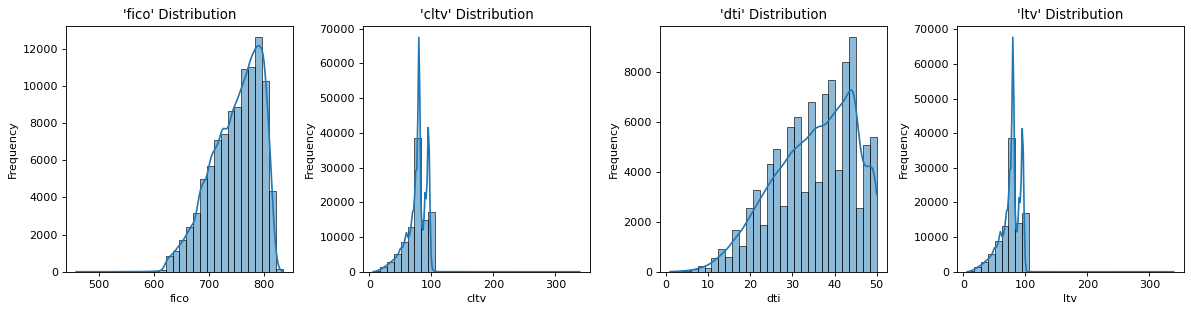

In [11]:
# Select numeric columns
numeric_missing = ['fico', 'cltv', 'dti', 'ltv']
# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(15, 4)) 
for i, col in enumerate(numeric_missing):
    sns.histplot(X_train[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"'{col}' Distribution")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

Given all four of the numerical features with missing values are skewed, we will implement median imputation in our preprocessing pipeline to best replace these missing values. 

**3.4 Investigating Relationships**

<Axes: >

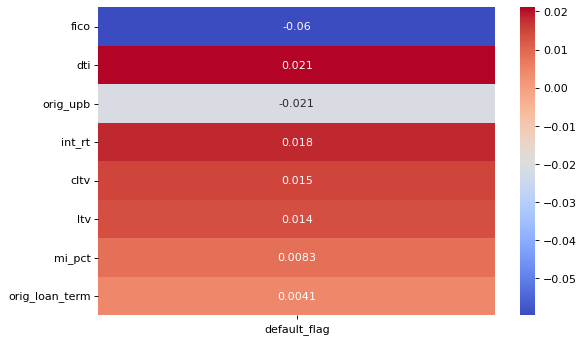

In [12]:
corr_matrix = pd.concat([X_train, y_train], axis=1).corr(numeric_only=True)
target_corr = corr_matrix[['default_flag']].drop('default_flag').sort_values(by='default_flag', key=abs, ascending=False)
sns.heatmap(target_corr, annot=True, cmap='coolwarm')

从相关性热力图可以看出，所有数值变量与违约标签 default_flag 之间的线性相关性都非常弱。这可能是由于数据集中违约样本极少，类别严重不平衡，导致皮尔森相关系数无法准确衡量变量的重要性。为了缓解这种问题，我们将在后续采用 SMOTE 技术对违约样本进行过采样，以提高模型对少数类的识别能力。

The correlation heatmap shows that all numerical features have very weak linear relationships with the target variable default_flag. This is likely due to the highly imbalanced nature of the dataset, where the proportion of default cases is extremely low. In such settings, traditional correlation metrics tend to understate the predictive value of features, as the minority class is underrepresented in the statistical estimation. To address this, we apply SMOTE (Synthetic Minority Over-sampling Technique) to rebalance the dataset by generating synthetic default samples. This improves the model’s ability to learn patterns associated with the rare class and enhances performance on imbalanced classification tasks.

**3.5 Data Transformations**

Since the variables are not on the same scale, we apply standardisation. Explain.

由于各变量的量纲不同，我们对数据进行了标准化处理。运用在pipeline中

**3.6 Feature Engineering**

To transform the categorical variables, we employ One-Hot Encoding. Explain

# Model Fitting and Tuning

*In this section you should detail and motivate your choice of model and describe the process used to refine, tune, and fit that model. You are encouraged to explore different models but you should NOT include a detailed narrative or code of all of these attempts. At most this section should briefly mention the methods explored and why they were rejected - most of your effort should go into describing the final model you are using and your process for tuning and validating it.*

*This section should include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

*Finally, you should also provide a comparison of your model with a baseline model of your choice on the test data but only briefly describe the baseline model considered.*

**4.1 Pipeline and Oversampling(SMOTE)**

In [13]:
# Using Pipeline for numerical and categorical
# Create lists for impution type
median_impute = ['fico', 'cltv', 'dti', 'ltv']
# Numerical imputer pipeline
numerical_transformer = Pipeline([
    ('impute', ColumnTransformer([
    ("median_impute", SimpleImputer(strategy='median'), median_impute)
], remainder='passthrough')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# Refit and transform the training set; transform the test set
X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)

print("Encoded feature matrix shape (training set):", X_train_enc.shape)

Encoded feature matrix shape (training set): (101364, 165)


After encoding, the dimensionality of the training feature matrix increases significantly from 24 to 165 due to the one-hot encoding of categorical variables. The pipeline ensures that the same transformations are consistently applied to both the training and testing data.

编码后，训练集特征矩阵的维度增加明显从24到165，这是由于对类别变量进行了独热编码。Pipeline确保相同变换应用于训练和测试数据。

类别不平衡处理： 在训练模型前，需要应对违约样本过少的问题。我们采用SMOTE算法对训练集过采样正类，使违约样本数量增加至与非违约相当，从而平衡训练数据。SMOTE通过插值合成新的少数类样本，较随机过采样能增加多样性。这里使用imblearn.over_sampling.SMOTE进行处理。为防止数据泄漏，我们仅对训练集做过采样，测试集保持真实分布。

In [14]:
# Apply SMOTE to oversample the training set
smote = SMOTE(random_state=0)
X_train_res, y_train_res = smote.fit_resample(X_train_enc, y_train)

print("Resampled training set shape:", X_train_res.shape, 
      "Positive class ratio:", y_train_res.mean())

Resampled training set shape: (201534, 165) Positive class ratio: 0.5


After oversampling, the number of training samples increases significantly, with default and non-default cases each accounting for 50%. For example, the original training set contained only a few hundred default cases. With SMOTE, a large number of synthetic default samples were generated, resulting in approximately 100,000 samples for each class. This balanced distribution provides the model with sufficient default cases to learn from, helping to alleviate the issue of the model being biased toward predicting the majority class. In the subsequent model training, we will use `X_train_res` and `y_train_res` as the training data.

过采样后训练集样本数成倍增加，违约与非违约样本数各占50%。例如，原训练集中违约样本仅几百条，经过SMOTE生成了大量合成违约样本，正负样本均约10万余条，各占一半，为模型提供了足够的违约案例学习。这样处理能缓解模型偏向预测多数类的问题。在后续模型训练中，我们将使用X_train_res, y_train_res作为训练数据。

**Using Filter and Random Forest to remove features again**

In [15]:
# Step1: Filter-based feature selection
filter_selector = SelectKBest(score_func=f_classif, k=50)
filter_selector.fit(X_train_res, y_train_res)
X_train_res_filter = filter_selector.transform(X_train_res)
# Step2: Random Forest feature selection
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train_res_filter, y_train_res)
model_selector = SelectFromModel(rf, prefit=True, threshold="median")
X_train_final = model_selector.transform(X_train_res_filter)
print("X_train_final shape:", X_train_final.shape)

X_train_final shape: (201534, 25)


In [16]:
numeric_features = numerical_features
onehot = preprocessor.named_transformers_['cat'].named_steps['onehot']
categorical_feature_names = onehot.get_feature_names_out(categorical_features)
feature_names_encoded = np.concatenate([numeric_features, categorical_feature_names])
# Step1 selection
filter_support = filter_selector.get_support(indices=True)
# Step2 selection based on Step1
rf_support = model_selector.get_support(indices=True)
final_feature_indices = filter_support[rf_support]
# Final feature selection
final_feature_names = feature_names_encoded[final_feature_indices]
print(final_feature_names)

['fico' 'mi_pct' 'cltv' 'dti' 'orig_upb' 'ltv' 'int_rt' 'dt_first_pi_11.0'
 'flag_fthb_N' 'flag_fthb_Y' 'channel_C' 'channel_R' 'st_FL'
 'prop_type_PU' 'prop_type_SF' 'loan_purpose_C' 'cnt_borr_1' 'cnt_borr_2'
 'property_val_1.0' 'property_val_3.0' 'msa_False' 'Nat_A_0' 'Nat_A_2'
 'Nat_A_3' 'Nat_A_8']


**4.2 Initial Model Training and Comparison**

使用五折交叉验证（5-fold CV）在训练集（过采样后）上评估每个模型的性能。评估指标侧重于违约类的识别能力，包括F1-score（正类）和ROC-AUC。由于数据不平衡，准确率在此问题上意义不大，模型可能通过预测所有样本为非违约而获得99%以上的准确率，但对我们毫无价值。因此我们更关注召回率Recall（捕获违约的比例）、精确率Precision（预测为违约中实际违约的比例）以及它们的综合F1，以及ROC曲线下面积AUC。

We evaluate the performance of each model on the oversampled training set using 5-fold cross-validation (5-fold CV). The evaluation focuses on the model's ability to identify default cases, using metrics such as the F1-score (for the positive class) and ROC-AUC. Due to the class imbalance in the data, accuracy is not a meaningful metric in this context — a model could achieve over 99% accuracy simply by predicting all samples as non-default, which would be of no practical use. Therefore, we place greater emphasis on Recall (the proportion of actual defaults correctly identified), Precision (the proportion of predicted defaults that are truly defaults), their harmonic mean (F1-score), and the Area Under the ROC Curve (AUC).

In [15]:
# 定义要评估的模型字典
models = {
    "LogisticRegression": LogisticRegression(max_iter=500, solver='liblinear'),
    "SVM (RBF)": SVC(kernel='rbf', probability=True),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(n_estimators=100),
    "NeuralNetwork": MLPClassifier(max_iter=50, hidden_layer_sizes=(50,))
}

# 在过采样后的训练集上进行5折交叉验证，计算每个模型的ROC-AUC得分
for name, clf in models.items():
    auc_scores = cross_val_score(clf, X_train_res, y_train_res, 
                                 cv=5, scoring='roc_auc')
    print(f"{name} 平均ROC-AUC: {auc_scores.mean():.3f}")


KeyboardInterrupt



# Discussion & Conclusions

*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, estimated parameters and relationships, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a banking official, who is understands the issues associated with mortgage defaults but may only have university level mathematics (not necessarily postgraduate statistics or machine learning). Your goal should be to highlight to this audience how your model can useful. You should also discuss potential limitations or directions of future improvement of your model.*

*Finally, you should include recommendations on factors that may increase the risk of default, which may be useful for the companies to improve their understanding of
mortgage defaults, and also to explain their decisions to clients and regulatory bodies. You should also use your model to inform the company of any active loans that are at risk of default.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

# Generative AI statement

*Include a statement on how generative AI was used in the project and report.*

# References

*Include references if any*

In [ ]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project2.ipynb